# Computing the Lagrangian Descriptors of Nonlinear Dynamical Systems

## Basic setup

BEFORE running this Notebook we assume the following 

* This notebook runs with Python Version `>= 3`

* `conda` si up-to-date. If not, in the terminal (Linux/Mac) or the `Conda Prompt` (Windows)

```bash
conda update --all
```

If you're running this notebook and it works fine. That's good news!

If you get error, please, try the proposed instructions in the next Subsection. 

## Package requirements

<span style='color:red'> <b> IMPORTANT </b> </span> 

* DO RUN the following lines, only if the current Notebook doesn't execute properly.
* DON'T RUN the following lines, if `requirements.txt` already satisfied or if Notebook runs fine. 

If `pip` not installed within `conda` environment, execute the cell below

```bash
conda install pip==20.0.2
```

__NOTE__ Wait for the above cell to finish executing before executing the next cell.

Install _package dependencies_

```bash
pip install -r requeriments.txt
```

## Functions

__NOTE__: For testing, execute all the cells below before executing/modifying all the benchmark examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp as integrator # RK45 (default)

INPUT PARAMETERS

In [2]:
###################################
# Integration parameters
t0 = 0
tau = 12
dt = 0.1
###################################
# Lagrangian descriptor parameters
p_norm = 1/2
flag_m = True
###################################
# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 3 # Phase-space Dimension + 1
shape = (Nx*Ny, dim)
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1;
perturbation_params = [0.15, 0.5]

In [3]:
def generate_points(GRID_PARAMETERS):
    x_min, x_max, Nx = GRID_PARAMETERS[0]
    y_min, y_max, Ny = GRID_PARAMETERS[1]
    points_x = np.linspace(x_min, x_max, Nx)
    points_y = np.linspace(y_min, y_max, Ny)    
    Y, X = np.meshgrid(points_y, points_x)  # Grid in phase-space
    mesh = np.transpose([X.flatten(), Y.flatten(), np.zeros(Nx*Ny)]) # 2D grid + a zero column for LDs
    return mesh

Turn phase-space vector field to high-dimensional vector field

__NOTE__ Parameters and function for implementation of Vairable Integration Time, using _Escape Box Condition_

In [4]:
box_x_min = -6
box_x_max = 6
box_y_min = -6
box_y_max = 6

box_BOUNDARIES = [
    [box_x_min, box_x_max],
    [box_y_min, box_y_max]
]

In [5]:
def check_if_points_escape_box(u, box_BOUNDARIES):
    x, y = u.T
    # Escape condition
    box_x_min, box_x_max = box_BOUNDARIES[0]
    box_y_min, box_y_max = box_BOUNDARIES[1]
    u_indices = (x >= box_x_min) & (x <= box_x_max) & (y >= box_y_min) & (y <= box_y_max)
    return u_indices

__NOTE__ Implementation with escape box condition for _VARIABLE Integration Time_

In [6]:
def vector_field_flat(t, points, vector_field, flag_m, box_BOUNDARIES = box_BOUNDARIES):
    u = points.reshape(shape)[:,:2] #code only written for 2D equations so far
    # Apply Escape condition
    u_inbox = check_if_points_escape_box(u, box_BOUNDARIES)
    # Define output vector field in combination with escape condition
    v = np.zeros(u.shape)
    v[u_inbox == True] = vector_field(t, u[u_inbox == True])
    # Calculate LD vector field
    LD_vec = np.zeros(len(u))
    LD_vec [u_inbox == True] = lag_des(v[u_inbox == True], flag_m)
    # Add LD
    v_out=np.column_stack((v, LD_vec))
    return v_out.flatten()

__NOTE__ Original implementation without escape box condition, that is,  _FIXED Integration Time_

In [7]:
def lag_des(u, flag_m, p_norm = 0.5):
    if flag_m: # p-norm LDs
        LD = np.sum(np.abs(u)**p_norm, axis=1)
    else:  # arclength LDs
        LD = np.sqrt(np.sum(u**2,axis=1))
    return LD

In [8]:
def compute_lagrangian_descriptor(points_initial, vector_field, time_interval, dt, flag_m = True):
    f = lambda x, y: vector_field_flat(x, y, vector_field, flag_m)
    t_initial, t_final = time_interval
    if (t_final - t_initial)*dt < 0:
        dt = -dt
    y0 = points_initial.flatten() # All initial conditions taken at once
    # Outputs from integration
    solution_object = integrator(f, time_interval, y0, t_eval=[t_final], rtol=1.0e-4)
    # Reshape output
    points_final = solution_object.y.reshape((shape[0], shape[1]))
    # Return all points, last coordinate
    return np.abs(points_final[:,-1])

In [9]:
def draw_lagrangian_descriptor(LD, flag_m, flag_type):
    LD = LD.reshape(Nx, Ny).T # Reshape 1D array
    #LD = LD / LD.max()  # Scale LD output
    ###################################
    # Plot LDs
    fig,ax = plt.subplots(1,1,dpi=100)
    
    points_x = np.linspace(x_min, x_max, Nx)
    points_y = np.linspace(y_min, y_max, Ny)    
    X, Y = np.meshgrid(points_x, points_y)

    contour = plt.contourf(X,Y,LD,cmap='bone',levels=200)
    ###################################
    # Customise appearance
    if flag_m:
        str_meth = ' '.join(['p-norm (p=',str(p_norm),')--'])
    else:
        str_meth = 'arclength --'
    
    if flag_type == 1:
        string_title = ['Forward LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    elif flag_type == 2:
        string_title = ['Backward LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    else:
        string_title = ['LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    
    string_title = ' '.join(string_title)
    
    ax.set_title(string_title, fontsize=12)
    ax.set_xlabel('x', fontsize=18)
    ax.set_ylabel('y', fontsize=18)
    ax.set_aspect('auto')

    fig.colorbar(contour) # Add color bar

    plt.show()

# Benchmark examples

## Vector fields

Define vector field $f(x,y) = (f_1, f_2)$

For for the Initial Value problem 

\begin{align*}
    \dot{x} &= dx/dt = f_1(x,y)\\
    \dot{y} &= dy/dt = f_2(x,y)
\end{align*}

with initial condition $(x_0, y_0) \in \mathbb{R}^2$ at time $t_0 \geq 0$

Hamilton Centre

In [10]:
def HamCenter1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    omega = 1
    v = np.array([ omega * y, - omega * x]).T
    return v

Hamilton Saddle 1D

In [11]:
def HamSaddle1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    lamda = 1
    v = np.array([ lamda * y, lamda * x]).T
    return v

Hamilton Duffing 1D

In [12]:
def forcing(t, u, flag_pert, perturbation_params):
    x, y = u.T
    pert = np.zeros((len(x),1))
    # Perturbation parameters
    A, freq = perturbation_params # Amplitude and Frequency
    if flag_pert == 1:
        perturbation = A * np.sin(freq*t)
    elif flag_pert == 2:
        perturbation = A * np.sech(t) * np.sin(freq*t)
    else:
        perturbation = perturbation
    
    return perturbation

In [13]:
def HamDuffing1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    perturbation = forcing(t, u, flag_pert, perturbation_params)
    v = np.array([y, x - x**3 + perturbation]).T
    return v

Hamilton Saddle-Node 1D

In [14]:
def HamSN1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    v = np.array([ y, -x -x**2]).T
    return v

In [15]:
def HamINVDUFF1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    # perturbation = forcing(t, u, flag_pert, perturbation_params)
    # v = np.array([y, - x + x**3 + perturbation]).T
    v = np.array([y, - x + x**3]).T
    return v

## Input parameters (duplicit)

In [16]:
###################################
# Integration parameters
t0 = 0
tau = 12
dt = 0.1
###################################
# Lagrangian descriptor parameters
p_norm = 1/2
flag_m = True
###################################
# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 3 # Phase-space Dimension + 1
shape = (Nx*Ny, dim)
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1;
perturbation_params = [0.15, 0.5]

## Compute and Visualise

### Hamilton Centre

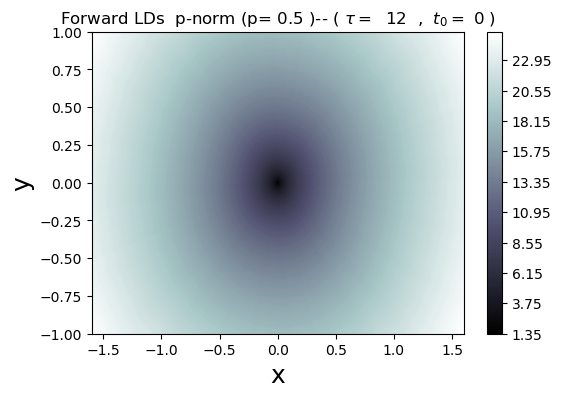

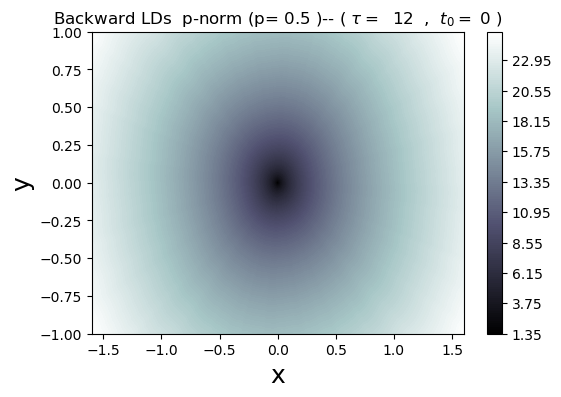

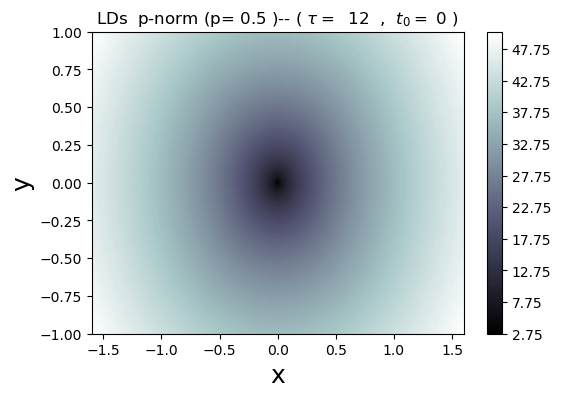

In [17]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamCenter1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_forward, flag_m, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_backward, flag_m, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, flag_m, 3)

### Hamilton Saddle

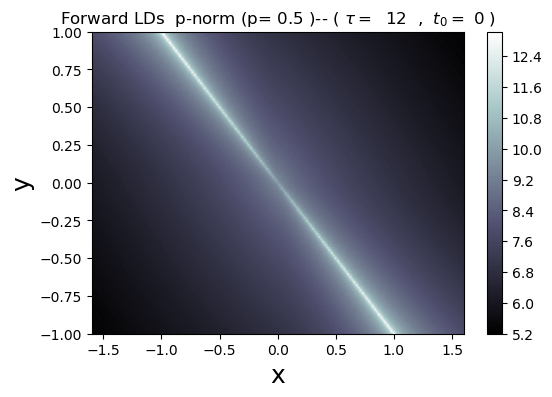

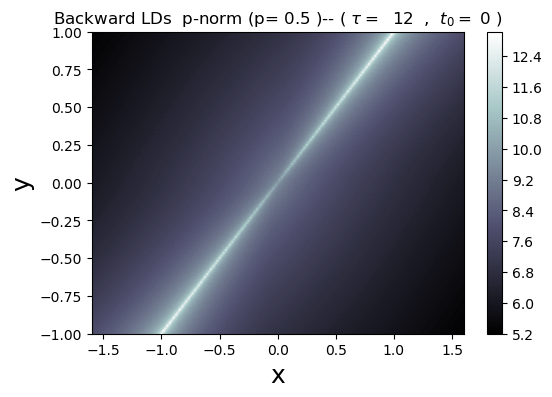

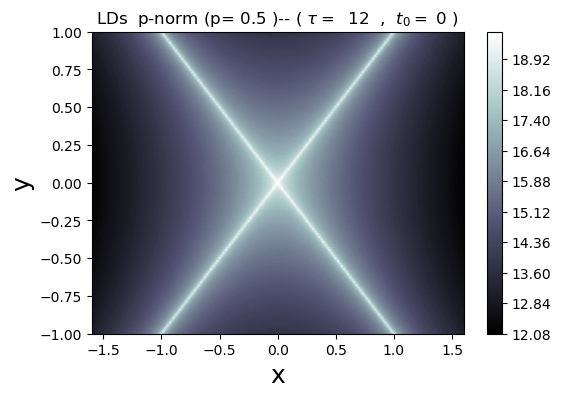

In [18]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamSaddle1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_forward, flag_m, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)

draw_lagrangian_descriptor(LD_backward, flag_m, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, flag_m, 3)

### Hamilton Duffing

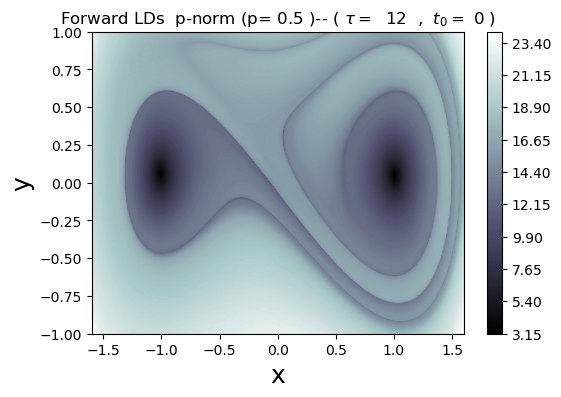

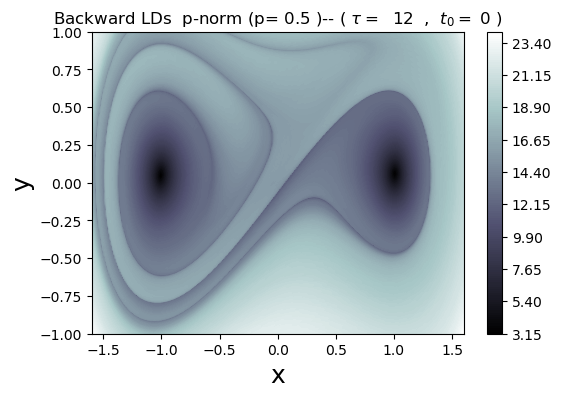

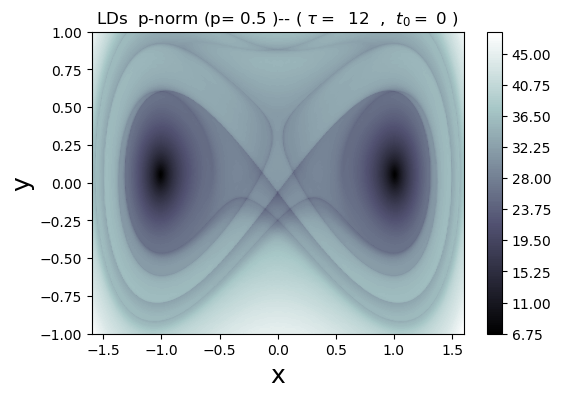

In [19]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamDuffing1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_forward, flag_m, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_backward, flag_m, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, flag_m, 3)

### Hamilton Saddle-Node

In [20]:
###################################
# Integration parameters
t0 = 0 # Initial time
tau = 8 # Time-interval length
dt = 0.1 # Timestep
###################################
# Lagrangian descriptor parameters
p_norm = 1/2 # p-value of Lp norm
flag_m = True
###################################
# Grid parameters
x_min,x_max = [-1.5, 1.5] # Grid limits X-axis
y_min,y_max = [-1, 1] # Grid limits Y-axis
Nx, Ny = [300, 300] # Number of points per axis

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 3 # Phase-space Dimension + 1
shape = (Nx*Ny, dim) # Shape of array of grid-points
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1 
perturbation_params = [0.15, 0.5] # Amplitude & Frequency, periodic pertubation

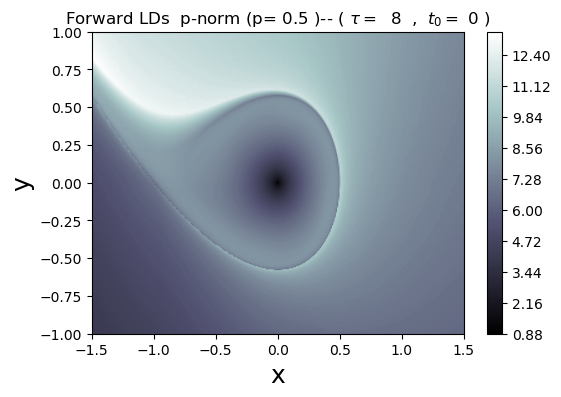

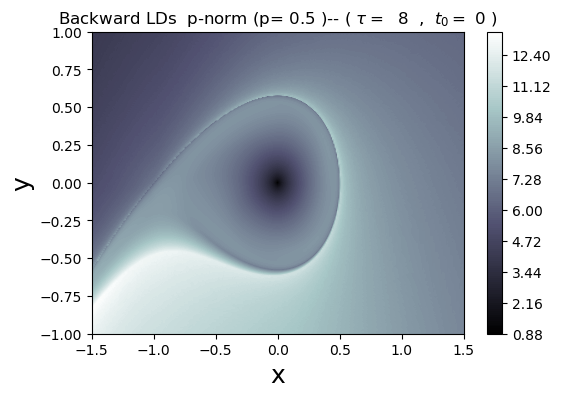

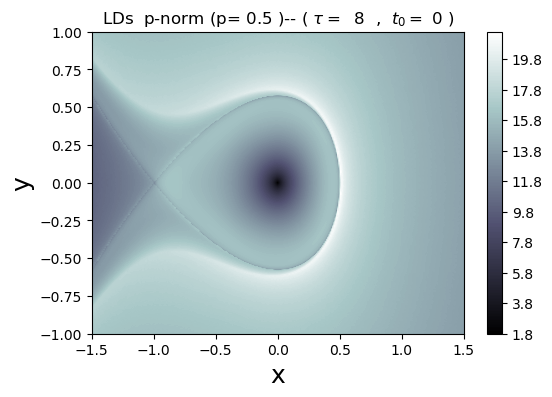

In [21]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamSN1D

# Compute and draw forward LD
time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_forward, flag_m, 1)

# Compute and draw backward LD
time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_backward, flag_m, 2)

# Compute and draw total LD
LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, flag_m, 3)

### Inverted Duffing Equation

In [22]:
###################################
# Integration parameters
t0 = 0 # Initial time
tau = 10 # Time-interval length
dt = 0.1 # Timestep
###################################
# Lagrangian descriptor parameters
p_norm = 1/2 # p-value of Lp norm
flag_m = True
###################################
# Grid parameters
x_min,x_max = [-1.5, 1.5] # Grid limits X-axis
y_min,y_max = [-1, 1] # Grid limits Y-axis
Nx, Ny = [200, 200] # Number of points per axis

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 3 # Phase-space Dimension + 1
shape = (Nx*Ny, dim) # Shape of array of grid-points
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1 
perturbation_params = [0.15, 0.5] # Amplitude & Frequency, periodic pertubation

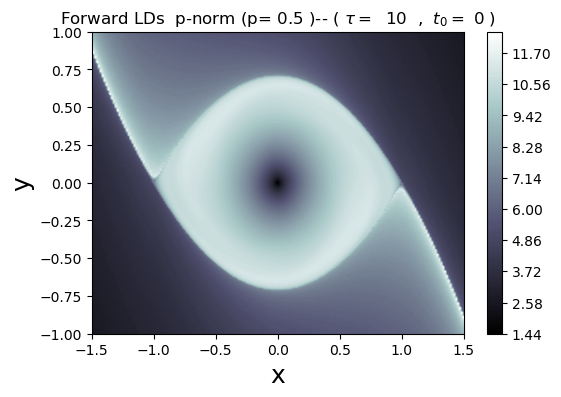

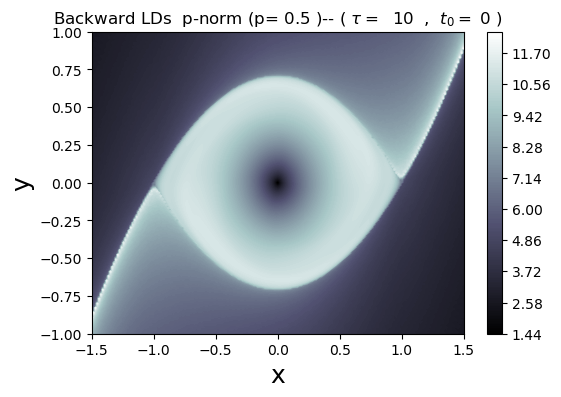

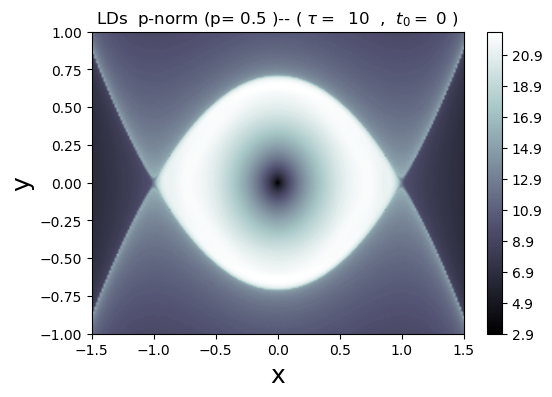

In [23]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamINVDUFF1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_forward, flag_m, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt, flag_m)
draw_lagrangian_descriptor(LD_backward, flag_m, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, flag_m, 3)